In [2]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

tweets = pd.read_csv("Tweets.csv")

#quick dataset overview
print(tweets.shape)
print(tweets.columns)
tweets.head() 

(14640, 15)
Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
#data cleaning
# Defensive column check
if 'sentiment' in tweets.columns and 'tweet' in tweets.columns:
    print("Data already cleaned — skipping column rename.")
else:
    tweets = tweets[['airline_sentiment', 'text']].copy()
    tweets.dropna(inplace=True)
    tweets.rename(columns={'airline_sentiment': 'sentiment', 'text': 'tweet'}, inplace=True)

tweets['sentiment'].value_counts()



sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [4]:
#text preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_tweet(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

tweets['clean_text'] = tweets['tweet'].apply(clean_tweet)
tweets.head() 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,sentiment,tweet,clean_text
0,neutral,@VirginAmerica What @dhepburn said.,said
1,positive,@VirginAmerica plus you've added commercials t...,plus youve added commercial experience tacky
2,neutral,@VirginAmerica I didn't today... Must mean I n...,didnt today must mean need take another trip
3,negative,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
4,negative,@VirginAmerica and it's a really big bad thing...,really big bad thing


In [5]:
#vectorization (TF-IDF)

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(tweets['clean_text'])
y = tweets['sentiment'] 

In [6]:
#train-test split and model training

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    negative       0.81      0.94      0.87      1835
     neutral       0.66      0.52      0.58       620
    positive       0.82      0.54      0.65       473

    accuracy                           0.79      2928
   macro avg       0.76      0.66      0.70      2928
weighted avg       0.78      0.79      0.77      2928



In [ ]:
#interactive confusion matrix using plotly
import numpy as np
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix

#computing confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

#converting to NumPy array
cm = np.array(cm, dtype=np.float64)

#calculating percentages for annotation
cm_percent = cm / cm.sum(axis=1, keepdims=True)
cm_percent = np.nan_to_num(cm_percent)  #avoiding NaN for zero rows

#creating annotations (counts + percentages)
annotations = [
    [f"{int(count)}<br>{perc:.2%}" for count, perc in zip(row_cm, row_pc)]
    for row_cm, row_pc in zip(cm, cm_percent)
]

#creating annotated heatmap
fig = ff.create_annotated_heatmap(
    z=cm_percent,
    x=list(model.classes_),
    y=list(model.classes_),
    annotation_text=annotations,
    colorscale='Blues',
    showscale=True
)

fig.update_layout(
    title='Confusion Matrix (Normalized by Row)',
    xaxis_title='Predicted Label',
    yaxis_title='True Label'
)

fig.show()



In [8]:


#generating classification report
report = classification_report(y_test, y_pred, target_names=model.classes_, output_dict=True)

#converting to DataFrame for easier manipulation
tweet_report = pd.DataFrame(report).transpose()

#selecting relevant metrics
metrics = tweet_report.loc[model.classes_, ['precision', 'recall', 'f1-score']]

#rounding values for clarity
metrics = metrics.round(3)

#creating annotated heatmap
fig = ff.create_annotated_heatmap(
    z=metrics.values,
    x=list(metrics.columns),
    y=list(metrics.index),
    annotation_text=metrics.applymap(lambda v: f"{v:.3f}").values,
    colorscale='Viridis',
    showscale=True
)

fig.update_layout(
    title="Classification Report (Precision, Recall, F1-Score)",
    xaxis_title="Metrics",
    yaxis_title="Classes",
    font=dict(size=12)
)

fig.show()

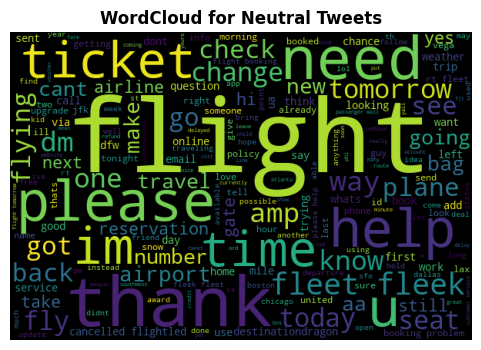

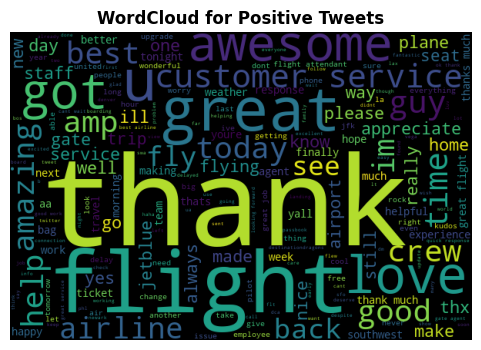

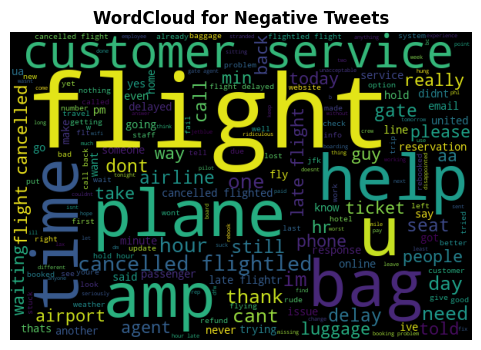

In [9]:
#wordclouds for sentiments
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for sentiment in tweets['sentiment'].unique():
    text = ' '.join(tweets[tweets['sentiment'] == sentiment]['clean_text'])
    plt.figure(figsize=(6,4))
    plt.imshow(WordCloud(width=600, height=400).generate(text))
    plt.title(f"WordCloud for {sentiment.capitalize()} Tweets", fontweight='bold')
    plt.axis("off")
    plt.show()


In [10]:
#sketch goal: trying naive bayes
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("Naive Bayes Results:")
print(classification_report(y_test, y_pred_nb)) 

Naive Bayes Results:
              precision    recall  f1-score   support

    negative       0.72      0.99      0.83      1835
     neutral       0.75      0.25      0.37       620
    positive       0.83      0.34      0.48       473

    accuracy                           0.73      2928
   macro avg       0.76      0.52      0.56      2928
weighted avg       0.74      0.73      0.68      2928



In [ ]:
#model evaluation- logistic regression vs. naive bayes
#comparing performance metrics
from sklearn.metrics import classification_report, accuracy_score
y_pred = model.predict(X_test) #logistic regression
y_pred_nb = nb.predict(X_test) #naive bayes

#logistic Regression metrics
print("Logistic Regression Performance:\n")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

#naive Bayes metrics
print("\nNaive Bayes Performance:\n")
print(classification_report(y_test, y_pred_nb))
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
 

Logistic Regression Performance:

              precision    recall  f1-score   support

    negative       0.81      0.94      0.87      1835
     neutral       0.66      0.52      0.58       620
    positive       0.82      0.54      0.65       473

    accuracy                           0.79      2928
   macro avg       0.76      0.66      0.70      2928
weighted avg       0.78      0.79      0.77      2928

Accuracy: 0.7851775956284153

Naive Bayes Performance:

              precision    recall  f1-score   support

    negative       0.72      0.99      0.83      1835
     neutral       0.75      0.25      0.37       620
    positive       0.83      0.34      0.48       473

    accuracy                           0.73      2928
   macro avg       0.76      0.52      0.56      2928
weighted avg       0.74      0.73      0.68      2928

Accuracy: 0.725068306010929


In [12]:
#creating confusion matrices
# Ensure labels are list type (not numpy arrays)
labels = list(y_test.unique())

#logistic regression confusion matrix
cm_lr = confusion_matrix(y_test, y_pred, labels=labels)

fig_lr = ff.create_annotated_heatmap(
    z=cm_lr,
    x=labels,
    y=labels,
    colorscale='Blues',
    showscale=True,
    annotation_text=cm_lr.astype(str)
)
fig_lr.update_layout(
    title="Confusion Matrix - Logistic Regression",
    xaxis_title="Predicted Label",
    yaxis_title="True Label"
)
fig_lr.show()

#naive bayes confusion matrix
cm_nb = confusion_matrix(y_test, y_pred_nb, labels=labels)

fig_nb = ff.create_annotated_heatmap(
    z=cm_nb,
    x=labels,
    y=labels,
    colorscale='Greens',
    showscale=True,
    annotation_text=cm_nb.astype(str)
)
fig_nb.update_layout(
    title="Confusion Matrix - Naive Bayes",
    xaxis_title="Predicted Label",
    yaxis_title="True Label"
)
fig_nb.show()


In [13]:
#comparing model accuracy using bar chart
import plotly.graph_objects as go

acc_lr = accuracy_score(y_test, y_pred)
acc_nb = accuracy_score(y_test, y_pred_nb)

fig = go.Figure([
    go.Bar(name='Logistic Regression', x=['Accuracy'], y=[acc_lr]),
    go.Bar(name='Naive Bayes', x=['Accuracy'], y=[acc_nb])
])

fig.update_layout(
    title="Model Accuracy Comparison",
    yaxis_title="Accuracy",
    barmode='group'
)
fig.show()


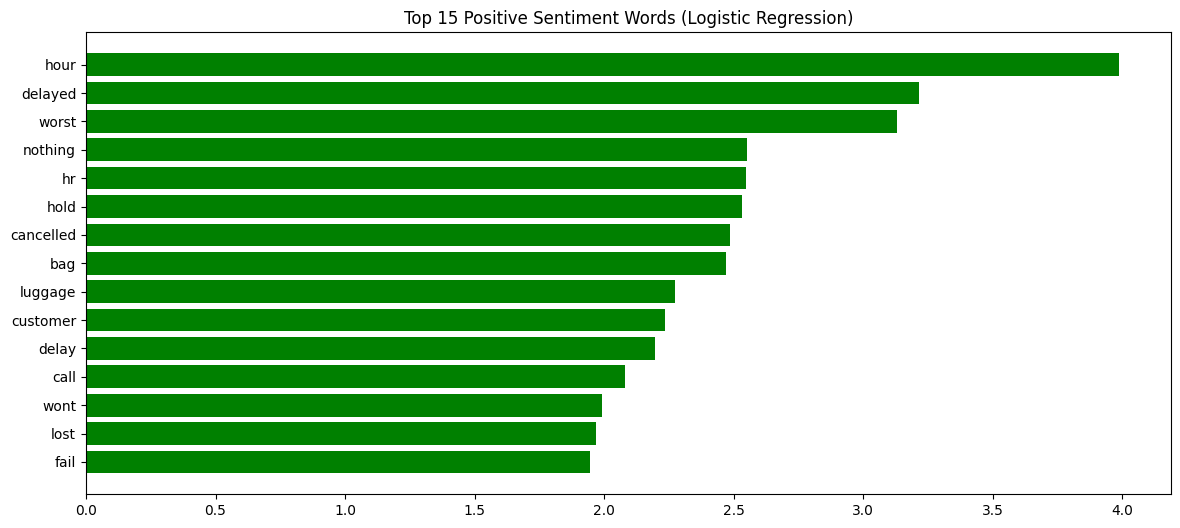

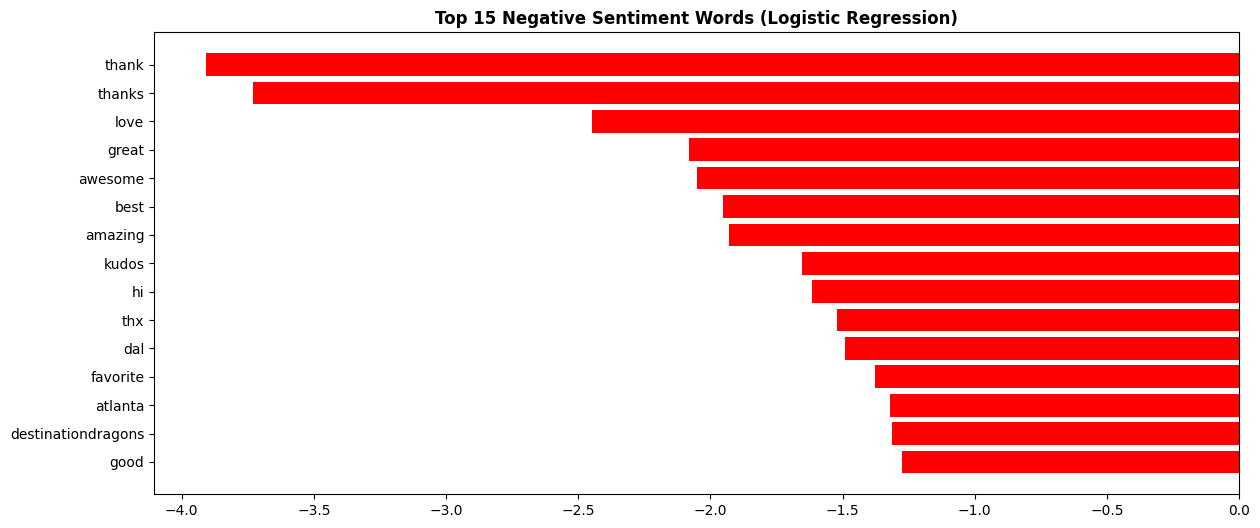

In [14]:
#model explainability - top words for each model
#logic regression
#getting feature names from TF-IDF
feature_names = vectorizer.get_feature_names_out()

#getting coefficients for each class
coef = model.coef_[0]  #assuming a binary sentiment: negative vs positive

#creating a dataframe for visualization
importance_tweets = pd.DataFrame({
    'word': feature_names,
    'coefficient': coef
})

#sortting words by influence
top_positive = importance_tweets.sort_values(by='coefficient', ascending=False).head(15)
top_negative = importance_tweets.sort_values(by='coefficient', ascending=True).head(15)

#plotting the charts
plt.figure(figsize=(14,6))
plt.barh(top_positive['word'], top_positive['coefficient'], color='green')
plt.title("Top 15 Positive Sentiment Words (Logistic Regression)")
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(14,6))
plt.barh(top_negative['word'], top_negative['coefficient'], color='red')
plt.title("Top 15 Negative Sentiment Words (Logistic Regression)", fontweight='bold')
plt.gca().invert_yaxis()
plt.show()
